In [349]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm
import math
import os
from filterpy.kalman import KalmanFilter

In [309]:
filePath = 'data/robot/test1_rec.txt'
targets = np.loadtxt(filePath)[1000:1500,0:3]
targets.shape

(500, 3)

(-0.25, 0.25)

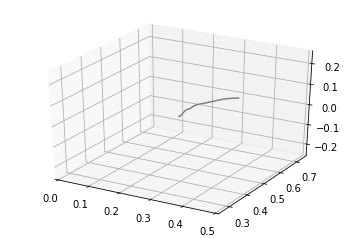

In [311]:
fig = plt.figure()
ax = plt.axes(projection='3d')
p = ax.plot3D(targets[:,0], targets[:,1], targets[:,2], 'gray')
ax.set_xlim(0.0,0.5)
ax.set_ylim(0.25,0.75)
ax.set_zlim(-0.25,0.25)

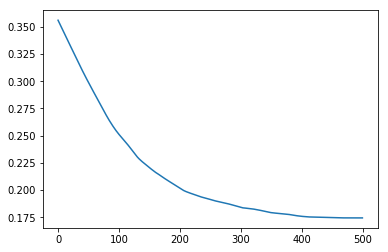

In [266]:
p = plt.plot(targets[:,0])

In [342]:
data = np.load('data/data-out_2020-02-25_16-06.npy')[:,:,:500]
#data = np.load('data/data_2020-02-25_16-06.npy')[:,:,:500]

In [343]:
import statsmodels.api as sm
from scipy.signal import savgol_filter
import time
import sys

[t,n,s] = data.shape
binSize = 100
l = s-binSize

tgtSin = 1.0-0.1*np.sin((np.pi/(0.3*l))*np.arange(l))
tgtLin = 1+np.arange(l)/l
tgtExp = np.exp(0.1*np.arange(l)/l)
tgtCon = np.repeat(1.0, l)

tgt = targets[:-binSize,:]

# FIXME intercept?

# TODO
# * do regression for at least 2 time steps
def estimate(target):
    yes = []
    t0 = time.time()
    for i in range(l):
        # Fit
        x = np.mean(data[:24,:,i:i+binSize], axis=2)
        y = np.tile(target[i], 24)
        model = sm.OLS(y, x)
        params = model.fit_regularized(alpha=0.0, L1_wt=0.0).params
        
        # Predict
        xe = np.mean(data[24,:,i:i+binSize], axis=1)
        ye = np.dot(xe.T, params)
        yes.append(ye)
        
        # Progress
        t1 = time.time()
        print("{}/{}, t = {}".format(i+1, l, np.round(t1-t0,2)), end="\r")
    return np.array(yes)

In [344]:
x = estimate(tgt[:,0])
y = estimate(tgt[:,1])
z = estimate(tgt[:,2])

#e = estimate(tgtExp)

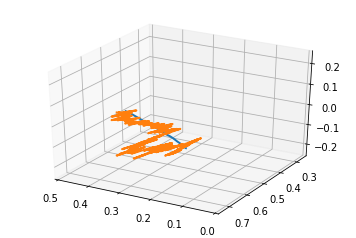

In [345]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot3D(tgt[:,0], tgt[:,1], tgt[:,2], linewidth=2.0)
#ax.plot3D(savgol_filter(x, 101, 1), savgol_filter(y, 101, 1), savgol_filter(z, 101, 1))
ax.plot3D(x, y, z, linewidth=2.0)
ax.set_xlim(0.0,0.5)
ax.set_ylim(0.25,0.75)
ax.set_zlim(-0.25,0.25)
ax.view_init(30, 120)

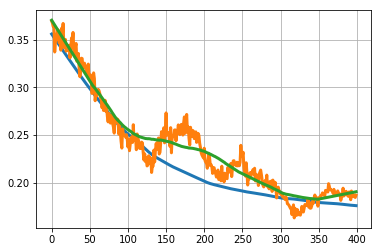

In [346]:
plt.plot(tgt[:,0], linewidth=3.0)
#plt.plot(savgol_filter(yes3, 201, 1), linewidth=3.0)
plt.plot(x, linewidth=3.0)
plt.plot(savgol_filter(x, 101, 1), linewidth=3.0)
#plt.xlim((0,100))
#plt.ylim((0.6,0.65))
plt.grid()

p = plt.show()

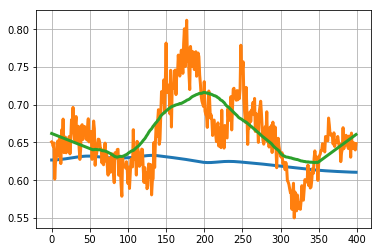

In [347]:
plt.plot(tgt[:,1], linewidth=3.0)
#plt.plot(savgol_filter(yes3, 201, 1), linewidth=3.0)
plt.plot(y, linewidth=3.0)
plt.plot(savgol_filter(y, 101, 1), linewidth=3.0)
#plt.xlim((0,100))
#plt.ylim((0.6,0.65))
plt.grid()

p = plt.show()

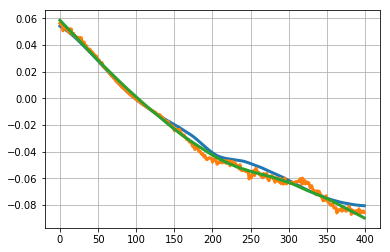

In [348]:
plt.plot(tgt[:,2], linewidth=3.0)
#plt.plot(savgol_filter(yes3, 201, 1), linewidth=3.0)
plt.plot(z, linewidth=3.0)
plt.plot(savgol_filter(z, 101, 1), linewidth=3.0)
#plt.xlim((0,100))
#plt.ylim((0.6,0.65))
plt.grid()

p = plt.show()

In [350]:
my_filter = KalmanFilter(dim_x=2, dim_z=1)


NameError: name 'Q_discrete_white_noise' is not defined